# Imports

In [6]:
import pandas as pd

from data_loader import MyDataLoader
from my_config import load_config, MyConfig

# Load (Preprocessed Step 1) DTU Solar Station data

In [7]:
PATH_TO_CONFIG = r'D:\Jetbrains\Python\Projects\solar_irradiance_nowcasting\configs\dni_only\OLS_DNI_LAG_60_1440_2880.json'
my_config: MyConfig = load_config(PATH_TO_CONFIG)
data_loader = MyDataLoader(my_config)
data_loader.load_data()
# data_loader.load_ecmwf_data()
data_loader.reindex_full_range()
data_loader.lag_features()
data_loader.prepare_df(drop_solar_altitude_below_0=False, drop_nan=False)
df = data_loader.get_df()

mask = df.isna().values
# make all nan values zero
df.fillna(0, inplace=True)
display(df.head())

,DNI,DNI_lag_60,DNI_lag_1440,DNI_lag_2880,DNI_CLEAR_SKY
2020-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0
2020-01-01 00:01:00,0.0,0.0,0.0,0.0,0.0
2020-01-01 00:02:00,0.0,0.0,0.0,0.0,0.0
2020-01-01 00:03:00,0.0,0.0,0.0,0.0,0.0
2020-01-01 00:04:00,0.0,0.0,0.0,0.0,0.0


# ARIMA model

In [8]:
import statsmodels.api as sm
model = sm.OLS(df[data_loader.get_target_names()], df[data_loader.get_feature_names()], missing='drop')
res_ols = model.fit()

print(res_ols.summary())
# res_ols.params['y_lag60'] is your φ60

fitted_values = res_ols.fittedvalues

                                 OLS Regression Results                                
Dep. Variable:                    DNI   R-squared (uncentered):                   0.705
Model:                            OLS   Adj. R-squared (uncentered):              0.705
Method:                 Least Squares   F-statistic:                          1.569e+06
Date:                Thu, 12 Jun 2025   Prob (F-statistic):                        0.00
Time:                        16:01:51   Log-Likelihood:                     -1.7044e+07
No. Observations:             2629441   AIC:                                  3.409e+07
Df Residuals:                 2629437   BIC:                                  3.409e+07
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

In [9]:
import datetime
import shutil
from _config import PATH_CHECKPOINT
from data_loader import SPLIT

test_predictions_df = pd.DataFrame({
    my_config.name: fitted_values.loc[data_loader.get_split(SPLIT.TEST).index]
}, index=data_loader.get_split(SPLIT.TEST).index)

time_str = datetime.datetime.now().strftime("%Y%m%d-%H%M%S_{0}".format(my_config.name))
PATH_CHECKPOINT = PATH_CHECKPOINT / time_str
PATH_CHECKPOINT.mkdir(parents=True, exist_ok=True)
shutil.copy(PATH_TO_CONFIG, PATH_CHECKPOINT / 'config.json')  # copy config file to checkpoint directory
test_predictions_df.to_pickle(PATH_CHECKPOINT / 'predictions.pkl')
test_predictions_df


,OLS_DNI_LAG_60_1440_2880
2024-01-01 00:00:00,0.000000
2024-01-01 00:01:00,0.000000
2024-01-01 00:02:00,0.000000
2024-01-01 00:03:00,0.000000
2024-01-01 00:04:00,0.000000
...,...
2024-12-30 23:56:00,0.106759
2024-12-30 23:57:00,0.118382
2024-12-30 23:58:00,0.118470
2024-12-30 23:59:00,0.127775


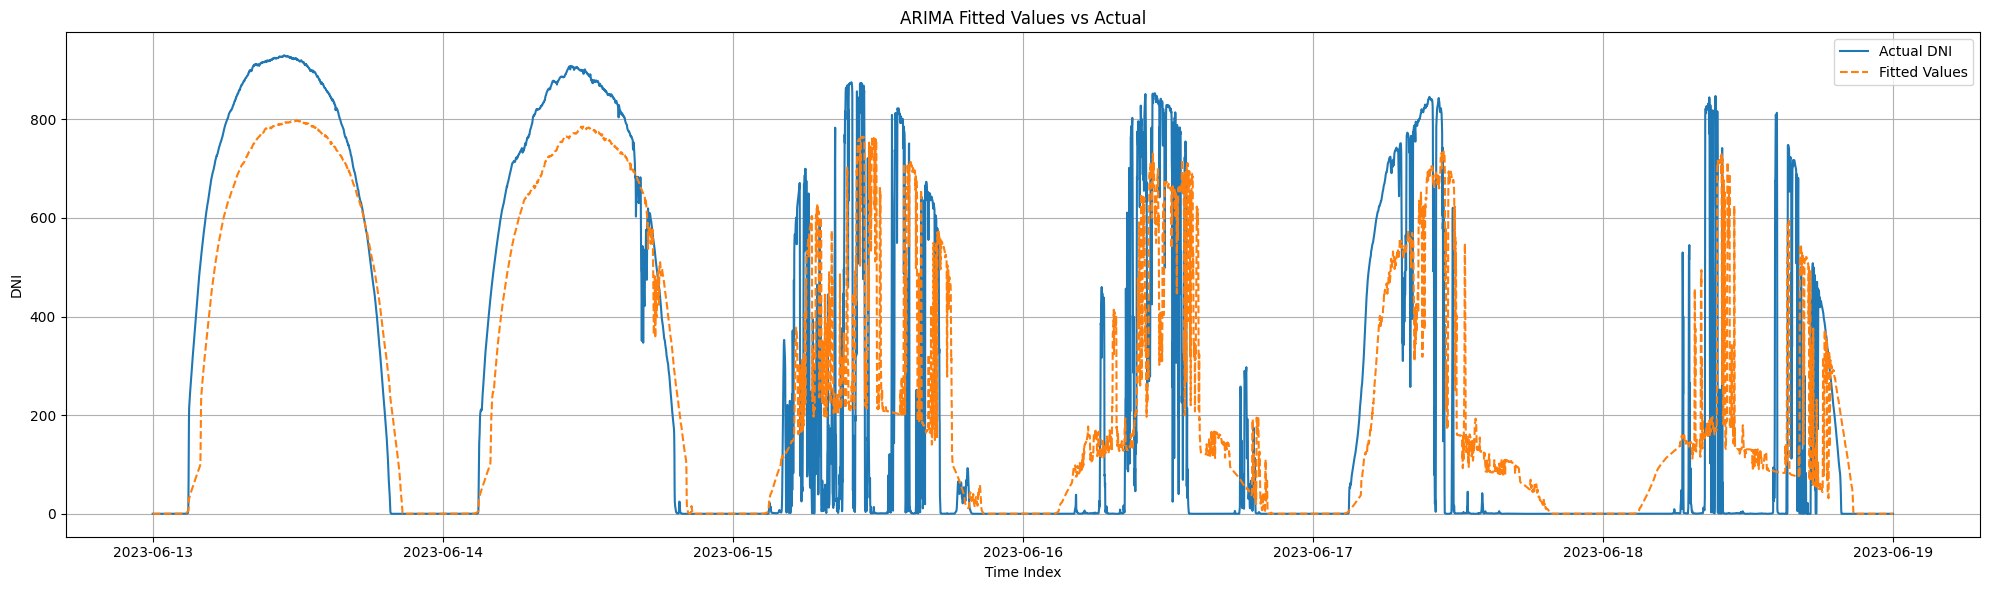

In [10]:
start = '2023-06-13'
end = '2023-06-18'
# Plot fitted values
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 6))
plt.plot(df.loc[start:end].index, df.loc[start:end]['DNI'], label='Actual DNI')
plt.plot(df.loc[start:end].index, fitted_values.loc[start:end], label='Fitted Values', linestyle='--')
plt.title('ARIMA Fitted Values vs Actual')
plt.xlabel('Time Index')
plt.ylabel('DNI')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()